# Kaggle
## Competição DSA de Machine Learning - Dezembro 2019

- Teste com redes neurais multicamadas (MLP)
- Se gostou ou achou útil, up-vote!! :)

**Versão 1.0.0: LB = 0.50744 / CV = ???**
- modelo: NN com 3 camadas
- features categoricas: removido
- dados missing: atribuído o valor medio
- feature selection: 25

**Versão 1.0.1: LB = 0.52913 / CV = 0.471703**
- modelo: NN com 3 camadas ocultas
- dados missing: removido colunas com mais de 50% de NA e as demais usei a média
- features categoricas: label encoder
- feature engineering: usando pacote Boruta (dica do Allyson)

**Versão 1.0.2: LB = 0.50098 / CV = 0.472390**
- modelo: NN com 3 camadas ocultas
- features engineering: Kernel_Feature_Engineering_v.1.0.0

**Versão 1.0.3: LB = ??? / CV = 0.478041 - 0.478498**
- modelo: NN com 3 camadas ocultas
- features engineering: Kernel_Feature_Engineering_v.1.0.0

# Importando as bibliotecas

In [1]:
# Importar os principais pacotes
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook as tqdm
import re
import random as rd
import os
import codecs
import time
import datetime
import gc
from numba import jit
from collections import Counter
import copy
from typing import Any

seed = 12345
np.random.seed(seed)
rd.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# Evitar que aparece os warnings
import warnings
warnings.filterwarnings("ignore")

# Seta algumas opções no Jupyter para exibição dos datasets
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

# Variavel para controlar o treinamento no Kaggle
TRAIN_OFFLINE = True

In [2]:
# Importa os pacotes de algoritmos
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb 

# Importa os pacotes de algoritmos de redes neurais (Keras)
import keras
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.utils import to_categorical
from keras.layers import Dense,Input,Flatten,concatenate,Dropout,Lambda,BatchNormalization
from keras.layers import Activation
from keras.models import Sequential, Model
from keras.callbacks import Callback,EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
import keras.backend as K
from keras.optimizers import Adam
from keras import optimizers
from keras.utils import np_utils

# Importa pacotes do sklearn
from sklearn import preprocessing
import sklearn.metrics as mtr
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, log_loss, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import scale, MinMaxScaler, StandardScaler
from sklearn import model_selection
from sklearn.utils import class_weight

from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection
from sklearn.decomposition import PCA, FastICA
from sklearn.decomposition import TruncatedSVD
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures

from sklearn.preprocessing import StandardScaler as SS
from sklearn.model_selection import train_test_split as TTS

from keras.callbacks import ReduceLROnPlateau as RLRP
from keras.callbacks import EarlyStopping as ES

Using TensorFlow backend.


# Carregando os dados de treino e teste

In [3]:
def read_data():
    
    if TRAIN_OFFLINE:
        print('Carregando arquivo dataset_treino.csv....')
        train = pd.read_csv('../dataset/dataset_treino.csv')
        print('dataset_treino.csv tem {} linhas and {} colunas'.format(train.shape[0], train.shape[1]))

        print('Carregando arquivo dataset_teste.csv....')
        test = pd.read_csv('../dataset/dataset_teste.csv')
        print('dataset_teste.csv tem {} linhas and {} colunas'.format(test.shape[0], test.shape[1]))

        
    else:
        print('Carregando arquivo dataset_treino.csv....')
        train = pd.read_csv('/kaggle/input/competicao-dsa-machine-learning-dec-2019/dataset_treino.csv')
        print('dataset_treino.csv tem {} linhas and {} colunas'.format(train.shape[0], train.shape[1]))
        
        print('Carregando arquivo dataset_treino.csv....')
        test = pd.read_csv('/kaggle/input/competicao-dsa-machine-learning-dec-2019/dataset_teste.csv')
        print('dataset_teste.csv tem {} linhas and {} colunas'.format(test.shape[0], test.shape[1]))
    
    return train, test

In [4]:
# Leitura dos dados
train, test = read_data()

Carregando arquivo dataset_treino.csv....
dataset_treino.csv tem 114321 linhas and 133 colunas
Carregando arquivo dataset_teste.csv....
dataset_teste.csv tem 114393 linhas and 132 colunas


In [5]:
# Leitura dos dados
train, test = read_data()
df = train.append(test)

Carregando arquivo dataset_treino.csv....
dataset_treino.csv tem 114321 linhas and 133 colunas
Carregando arquivo dataset_teste.csv....
dataset_teste.csv tem 114393 linhas and 132 colunas


In [6]:
# Verificar a quantidade de features numericas e categoricas

numerical_feats = df.dtypes[df.dtypes != "object"]
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = df.dtypes[df.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  114
Number of Categorical features:  19


# Feature Engineering

In [7]:
# Removendo alguns outliers
df = df[df['v129'] <= 2]
df = df[df['v3'] == 'C']

In [9]:
# Ajustando o skewness de algumas features com logaritmo
df["v19"]  = np.log1p(df["v19"])
df["v105"] = np.log1p(df["v105"])
df["v119"] = np.log1p(df["v119"])
#df["v124"] = np.log1p(df["v124"])
#df["v23"]  = np.log1p(df["v23"])
#df["v39"]  = np.log1p(df["v39"])
#df["v68"]  = np.log1p(df["v68"])

In [10]:
# Remove colunas com alta correlacao entre si ou com mais de 95% com zeros
#df = df.drop(columns = ['v12','v128','v13','v25','v32','v33','v34','v38','v41','v43','v46',
#                           'v49','v53','v54','v55','v60','v63','v64','v65','v67','v73','v76','v77',
#                           'v8','v83','v87','v89','v95','v96','v97'], axis = 1)

In [11]:
# Transformando as features categorias com LabelEncoder
le = LabelEncoder()

for i, col in enumerate(df):
    if df[col].dtype == 'object':
        df[col] = le.fit_transform(np.array(df[col].astype(str)).reshape((-1,)))

In [12]:
scaler = StandardScaler()
for c in df.columns:
    col_type = df[c].dtype
    #if col_type == 'float64' and c != 'target':
    if c != 'ID' and c != 'target':
        df[c] = scaler.fit_transform(df[c].values.reshape(-1, 1))

In [13]:
# Realizando tratamento de missing value
for c in df.columns:
    if c != 'ID' and c != 'target':
        df[c].fillna(df[c].median(),inplace=True)

In [14]:
# Add decomposed components: PCA / ICA etc.
n_comp = 12

# tSVD
tsvd = TruncatedSVD(n_components=n_comp, random_state=42)
tsvd_results_df = tsvd.fit_transform(df.drop(columns = ['ID','target'], axis = 1))

# PCA
pca = PCA(n_components=n_comp, random_state=42)
pca2_results_df = pca.fit_transform(df.drop(columns = ['ID','target'], axis = 1))

# ICA
ica = FastICA(n_components=n_comp, random_state=42)
ica2_results_df = ica.fit_transform(df.drop(columns = ['ID','target'], axis = 1))

# GRP
grp = GaussianRandomProjection(n_components=n_comp, eps=0.1, random_state=42)
grp_results_df = grp.fit_transform(df.drop(columns = ['ID','target'], axis = 1))

# SRP
srp = SparseRandomProjection(n_components=n_comp, dense_output=True, random_state=42)
srp_results_df = srp.fit_transform(df.drop(columns = ['ID','target'], axis = 1))

In [15]:
# Append decomposition components to datasets
for i in range(1, n_comp+1):
    df['pca_' + str(i)]  = pca2_results_df[:,i-1]
    df['ica_' + str(i)]  = ica2_results_df[:,i-1]
    df['tsvd_' + str(i)] = tsvd_results_df[:,i-1]
    df['grp_' + str(i)]  = grp_results_df[:,i-1]
    df['srp_' + str(i)]  = srp_results_df[:,i-1] 

In [16]:
print(df.shape)
df.head()

(217600, 193)


,ID,target,v1,v10,v100,v101,v102,v103,v104,v105,v106,v107,v108,v109,v11,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119,v12,v120,v121,v122,v123,v124,v125,v126,v127,v128,v129,v13,v130,v131,v14,v15,v16,v17,v18,v19,v2,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v3,v30,v31,v32,v33,v34,v35,v36,v37,v38,v39,v4,v40,v41,v42,v43,v44,v45,v46,v47,v48,v49,v5,v50,v51,v52,v53,v54,v55,v56,v57,v58,v59,v6,v60,v61,v62,v63,v64,v65,v66,v67,v68,v69,v7,v70,v71,v72,v73,v74,v75,v76,v77,v78,v79,v8,v80,v81,v82,v83,v84,v85,v86,v87,v88,v89,v9,v90,v91,v92,v93,v94,v95,v96,v97,v98,v99,pca_1,ica_1,tsvd_1,grp_1,srp_1,pca_2,ica_2,tsvd_2,grp_2,srp_2,pca_3,ica_3,tsvd_3,grp_3,srp_3,pca_4,ica_4,tsvd_4,grp_4,srp_4,pca_5,ica_5,tsvd_5,grp_5,srp_5,pca_6,ica_6,tsvd_6,grp_6,srp_6,pca_7,ica_7,tsvd_7,grp_7,srp_7,pca_8,ica_8,tsvd_8,grp_8,srp_8,pca_9,ica_9,tsvd_9,grp_9,srp_9,pca_10,ica_10,tsvd_10,grp_10,srp_10,pca_11,ica_11,tsvd_11,grp_11,srp_11,pca_12,ica_12,tsvd_12,grp_12,srp_12
0,3,1.0,-0.275654,-0.987378,1.067835,0.674750,-0.058035,-0.759300,-1.209903,-0.786148,0.288279,1.181801,0.278535,-0.046171,1.258236,1.024331,-1.974168,0.889489,0.864307,0.769349,-4.055820,-0.503088,-0.453998,-1.214172,-1.221152,-0.858905,-0.316689,-1.430060,0.655249,-0.605648,-0.418600,-0.972244,0.254044,-0.078336,0.016498,-0.466762,-0.793909,-1.023106,0.995685,-0.268430,-0.998675,2.044445,-0.060052,-1.130556,-0.850814,0.442069,0.955301,0.705230,1.405509,-0.277626,-0.963439,-0.527301,-0.268266,0.783797,-1.671470,0.539102,0.0,-1.294630,-0.453732,-0.960028,-1.175528,0.428994,0.197948,-0.885709,-0.544293,-0.155959,1.156430,-0.177018,-0.844050,0.482030,-0.215068,-0.303230,-0.121756,0.338058,-0.523561,-0.943312,-0.191223,0.083027,-0.390014,-0.493190,0.012067,0.126864,1.301914,-0.527220,-0.322817,0.500024,-0.159813,-1.044822,0.162719,0.280774,-0.220197,0.606402,-0.112236,-0.516334,0.033841,1.313802,1.661200,0.034902,-0.999835,4.054921,1.172564,-0.199172,0.701259,-0.517205,-1.036249,-0.073551,0.714585,-0.103087,-0.000794,-2.592016,0.224784,-0.532054,0.720065,0.092164,0.710813,-1.438321,-0.342150,-0.786954,-0.755194,-0.189619,1.346015,-0.507331,0.493548,-0.316868,-1.117668,-0.523471,0.238570,-0.401760,-0.707347,0.888226,-1.112682,0.513062,-0.110201,-3.585664,-0.002524,-3.917597,0.554970,-1.166822,-2.922923,-0.001239,-3.322619,2.089918,-7.100143,-0.959253,0.001249,-1.083140,-0.881790,-2.376196,0.120889,0.000223,0.123400,-4.786253,1.850191,0.858335,0.000004,0.862062,-1.035636,-2.390488,-0.859693,0.001271,-0.840062,-1.687347,0.625513,-0.584567,0.000831,-0.588055,2.151814,0.566630,-0.698610,-0.002375,-0.654680,2.527350,-2.271907,1.361426,-0.001013,1.302701,-2.263188,-0.052533,0.868118,0.002003,0.698083,4.037740,-5.547656,0.734112,-0.002135,0.584343,3.229630,1.334592,-1.669155,-0.000162,-1.209420,-5.045614,3.860268
1,4,1.0,-0.152544,-0.361247,0.347878,-0.096819,-0.234845,-0.143543,-0.149729,0.754226,0.105368,-0.949382,-0.345458,0.040973,0.059764,-0.976247,-0.173830,1.905236,-0.802408,-1.267794,-0.036461,-0.096978,0.657217,-0.112657,-0.157795,-0.366415,-0.200869,-0.222199,-0.041031,-0.316561,-0.148388,-1.562948,-0.115163,-0.167718,-0.047083,-0.466762,-0.172713,-0.292016,-0.134309,-0.268431,-0.124982,0.009864,-0.136239,-0.106147,-0.237748,-0.153884,0.233301,-0.230905,-0.285847,-0.277625,-0.963439,0.479715,-0.093490,-0.082764,-0.019236,0.071174,0.0,-1.294630,-0.453732,-0.117536,-0.220666,-1.360801,-0.036843,0.504732,-0.186837,-0.155959,-0.366315,0.058662,1.240442,0.022154,0.012366,-0.097738,-0.001877,0.005302,0.296723,-0.423033,-0.065618,0.007337,0.234703,-0.071136,-0.029223,0.126864,0.075014,-0.042617,-0.225531,1.000102,-0.014516,-0.347035,-0.030960,-0.040551,-0.087151,0.236496,1.368007,0.303106,-0.081848,0.222002,-0.748262,0.025196,0.312371,0.033579,-0.053059,-0.083837,0.701259,0.684646,-0.128398,-0.073551,0.714585,-0.158709,0.051393,-0.000125,-0.153407,0.298332,-0.112075,-0.020537,-0.759959,-0.221131,-0.197192,-0.164700,-0.135502,-0.090769,-0.155783,0.436395,0.016196,0.006097,-0.687424,-0.150764,-0.099318,-0.1297

# Feature Selection

In [17]:
treino = df[df['target'].notnull()]
teste = df[df['target'].isnull()]

In [18]:
# Importância do Atributo com o Random Forest Regressor
X_ = treino.drop(['ID','target'], axis=1)
y_ = treino['target']

# Criação do Modelo - Feature Selection
modeloRF = RandomForestClassifier(bootstrap=False, 
                                 max_features=0.3, 
                                 min_samples_leaf=15, 
                                 min_samples_split=8, 
                                 n_estimators=50, 
                                 n_jobs=-1, 
                                 random_state=42)
modeloRF.fit(X_, y_)

# Convertendo o resultado em um dataframe
feature_importance_df = pd.DataFrame(treino.drop(['ID','target'], axis=1).columns,columns=['Feature'])
feature_importance_df['importance'] = pd.DataFrame(modeloRF.feature_importances_.astype(float))

# Realizando a ordenacao por Importancia (Maior para Menor)
result = feature_importance_df.sort_values('importance',ascending=False)
print(result)

     Feature  importance
77       v50    0.148536
94       v66    0.043550
180   srp_10    0.020940
160    srp_6    0.020674
56       v31    0.016957
108      v79    0.015296
146    pca_4    0.014349
148   tsvd_4    0.013262
23       v12    0.013094
13      v110    0.012757
73       v47    0.012399
132    ica_1    0.011449
137    ica_2    0.010966
1        v10    0.009958
17      v114    0.009801
83       v56    0.009724
174    grp_9    0.009468
59       v34    0.009433
157    ica_6    0.009184
46       v22    0.008927
66       v40    0.008920
172    ica_9    0.008823
184   grp_11    0.008469
139    grp_2    0.008451
45       v21    0.008432
164    grp_7    0.008307
167    ica_8    0.008080
179   grp_10    0.008023
134    grp_1    0.007994
154    grp_5    0.007894
176   pca_10    0.007574
169    grp_8    0.007536
155    srp_5    0.007502
149    grp_4    0.007485
189   grp_12    0.007367
153   tsvd_5    0.007297
159    grp_6    0.007087
188  tsvd_12    0.006990
185   srp_11    0.006962


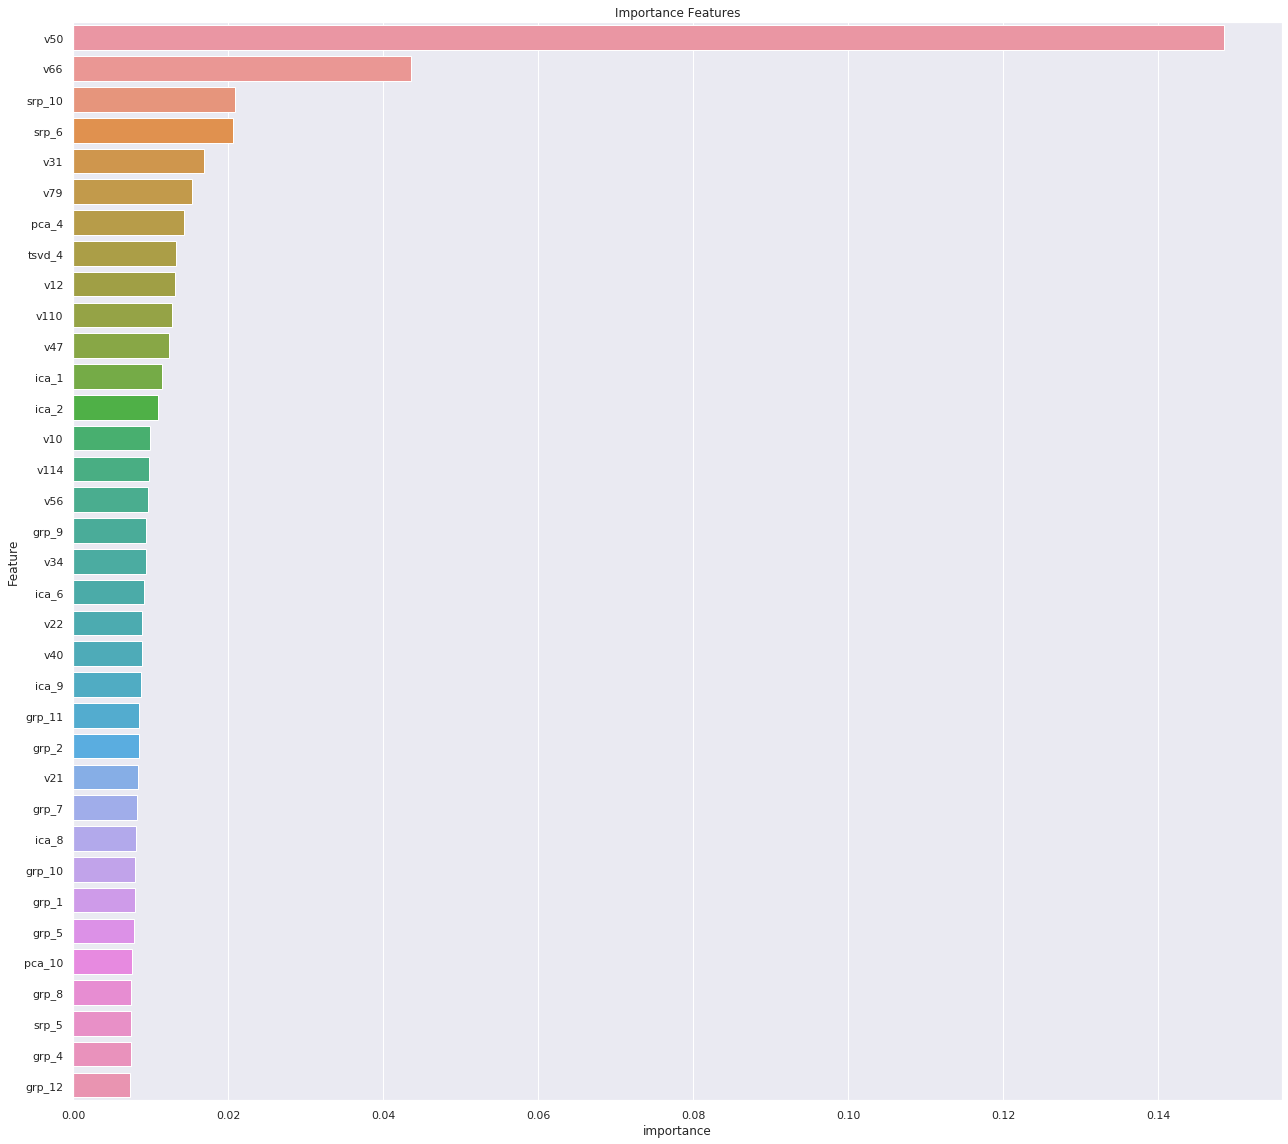

In [20]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:35].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(18,16))
sns.barplot(x="importance",
           y="Feature",
           data=best_features.sort_values(by="importance",
                                          ascending=False))
plt.title('Importance Features')
plt.tight_layout()

# Algoritmo Neural Network MLP

In [25]:
# Criar um dataset somente com as colunas mais importantes conforme Feature Selection
new_X = treino.loc[:,best_features['Feature']]

# Padronizando os dados de treino
scaler = StandardScaler()
train_x = scaler.fit_transform(new_X)
    
# Separando features preditoras e target
#train_x = new_df.drop(['ID','target'], axis=1)
train_y = np_utils.to_categorical(treino['target'])

# Verificando o shape dos datasets depois dos ajustes
# Neste momento está pronto para ser usado pelo treinamento
train_x.shape, train_y.shape

((108764, 35), (108764, 2))

In [26]:
# Limpeza da memória
gc.collect()

40

In [29]:
# Criando função para treinar a rede neural
def get_nn(x_tr,y_tr,x_val,y_val,shape):
    K.clear_session()
    
    # Cria a estrutura da rede neural com 3 camadas ocultas
    inp = Input(shape = (x_tr.shape[1],))

    x = Dense(1024, input_dim=x_tr.shape[1], activation='relu')(inp)
    x = Dropout(0.5)(x)    
    x = BatchNormalization()(x)

    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)    
    x = BatchNormalization()(x)
    
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.1)(x)    
    x = BatchNormalization()(x)
    
    out = Dense(2, activation='softmax')(x)
    model = Model(inp,out)
    
    model.compile(optimizer = optimizers.adam(lr = 0.09, decay = 0.01),
                  loss='categorical_crossentropy', 
                  metrics=['categorical_accuracy'])
    
    # Realiza a parada mais cedo quando percebe overfitting
    es = EarlyStopping(monitor='val_loss', 
                       mode='min',
                       restore_best_weights=True, 
                       verbose=1, 
                       patience=20)

    # Realiza checkpoint durante o treinamento
    mc = ModelCheckpoint('best_model.h5',
                         monitor='val_loss',
                         mode='min',
                         save_best_only=True, 
                         verbose=1, 
                         save_weights_only=True)

    # Realize o ajuste na Learning Rate durante o treinamento
    rl = ReduceLROnPlateau(monitor='val_loss', 
                           factor=0.1, 
                           patience=10, 
                           verbose=1, 
                           epsilon=1e-4, 
                           mode='min')

    # Realiza o fit do modelo
    model.fit(x_tr, y_tr,
              validation_data=[x_val, y_val],
              callbacks=[es,mc,rl],
              epochs=250, 
              batch_size=1024,
              verbose=1,
              shuffle=True)
    
    # Carrega os melhores pesos
    model.load_weights("best_model.h5")
    
    # Realiza as previsões
    y_pred = model.predict(x_val)
    y_valid = y_val
             
    # Calcula o log loss
    logloss = log_loss(y_valid, y_pred, eps=1e-15)

    return model, logloss

In [30]:
%%time

# Bloco para executar a rede neural a cada passada do KFold
# Vamos realizar 2 loops com 5 kfolds e apurar a média
loop = 2
fold = 5

# Definindo listas que serão preenchidas durante o loop for
oof_nn = np.zeros([loop, train_y.shape[0], train_y.shape[1]])
models_nn = []
logloss_csv_nn = []

# Treinando o modelo
for k in range(loop):
    kfold = KFold(fold, random_state = 42 + k, shuffle = True)
    for k_fold, (tr_inds, val_inds) in enumerate(kfold.split(train_y)):
        print("-----------")
        print(f'Loop {k+1}/{loop}' + f' Fold {k_fold+1}/{fold}')
        print("-----------")
        
        tr_x, tr_y = train_x[tr_inds], train_y[tr_inds]
        val_x, val_y = train_x[val_inds], train_y[val_inds]
        
        # Train NN
        nn, logloss_nn = get_nn(tr_x, tr_y, val_x, val_y, shape=val_x.shape[0])
        models_nn.append(nn)
        print("the %d fold Log-Loss (NN) is %f"%((k_fold+1), logloss_nn))
        logloss_csv_nn.append(logloss_nn)
        
        #Predict OOF
        oof_nn[k, val_inds, :] = nn.predict(val_x)
        
    print("PARTIAL: mean Log-Loss (NN) is %f"%np.mean(logloss_csv_nn))        

-----------
Loop 1/2 Fold 1/5
-----------
Train on 87011 samples, validate on 21753 samples
Epoch 1/250
87011/87011 [==============================] - 3s 33us/step - loss: 0.9580 - categorical_accuracy: 0.7201 - val_loss: 1.4611 - val_categorical_accuracy: 0.4084

Epoch 00001: val_loss improved from inf to 1.46107, saving model to best_model.h5
Epoch 2/250
87011/87011 [==============================] - 2s 26us/step - loss: 0.5188 - categorical_accuracy: 0.7565 - val_loss: 0.6158 - val_categorical_accuracy: 0.6438

Epoch 00002: val_loss improved from 1.46107 to 0.61580, saving model to best_model.h5
Epoch 3/250
87011/87011 [==============================] - 2s 27us/step - loss: 0.5143 - categorical_accuracy: 0.7575 - val_loss: 0.5222 - val_categorical_accuracy: 0.7525

Epoch 00003: val_loss improved from 0.61580 to 0.52224, saving model to best_model.h5
Epoch 4/250
87011/87011 [==============================] - 2s 27us/step - loss: 0.5086 - categorical_accuracy: 0.7586 - val_loss: 0.508

87011/87011 [==============================] - 5s 59us/step - loss: 0.4878 - categorical_accuracy: 0.7725 - val_loss: 0.4888 - val_categorical_accuracy: 0.7722

Epoch 00034: val_loss improved from 0.48896 to 0.48885, saving model to best_model.h5
Epoch 35/250
87011/87011 [==============================] - 6s 68us/step - loss: 0.4871 - categorical_accuracy: 0.7725 - val_loss: 0.4878 - val_categorical_accuracy: 0.7724

Epoch 00035: val_loss improved from 0.48885 to 0.48780, saving model to best_model.h5
Epoch 36/250
87011/87011 [==============================] - 6s 64us/step - loss: 0.4889 - categorical_accuracy: 0.7714 - val_loss: 0.4879 - val_categorical_accuracy: 0.7727

Epoch 00036: val_loss did not improve from 0.48780
Epoch 37/250
87011/87011 [==============================] - 6s 66us/step - loss: 0.4866 - categorical_accuracy: 0.7727 - val_loss: 0.4892 - val_categorical_accuracy: 0.7725

Epoch 00037: val_loss did not improve from 0.48780
Epoch 38/250
87011/87011 [=================


Epoch 00068: val_loss did not improve from 0.48309
Epoch 69/250
87011/87011 [==============================] - 6s 66us/step - loss: 0.4816 - categorical_accuracy: 0.7754 - val_loss: 0.4834 - val_categorical_accuracy: 0.7747

Epoch 00069: val_loss did not improve from 0.48309
Epoch 70/250
87011/87011 [==============================] - 6s 69us/step - loss: 0.4806 - categorical_accuracy: 0.7774 - val_loss: 0.4833 - val_categorical_accuracy: 0.7747

Epoch 00070: val_loss did not improve from 0.48309
Epoch 71/250
87011/87011 [==============================] - 6s 69us/step - loss: 0.4807 - categorical_accuracy: 0.7764 - val_loss: 0.4832 - val_categorical_accuracy: 0.7747

Epoch 00071: val_loss did not improve from 0.48309
Epoch 72/250
87011/87011 [==============================] - 6s 66us/step - loss: 0.4808 - categorical_accuracy: 0.7766 - val_loss: 0.4835 - val_categorical_accuracy: 0.7746

Epoch 00072: val_loss did not improve from 0.48309
Epoch 73/250
87011/87011 [======================


Epoch 00009: val_loss improved from 0.49567 to 0.49452, saving model to best_model.h5
Epoch 10/250
87011/87011 [==============================] - 6s 68us/step - loss: 0.4963 - categorical_accuracy: 0.7658 - val_loss: 0.4921 - val_categorical_accuracy: 0.7695

Epoch 00010: val_loss improved from 0.49452 to 0.49210, saving model to best_model.h5
Epoch 11/250
87011/87011 [==============================] - 6s 68us/step - loss: 0.4954 - categorical_accuracy: 0.7666 - val_loss: 0.4905 - val_categorical_accuracy: 0.7706

Epoch 00011: val_loss improved from 0.49210 to 0.49046, saving model to best_model.h5
Epoch 12/250
87011/87011 [==============================] - 6s 66us/step - loss: 0.4948 - categorical_accuracy: 0.7676 - val_loss: 0.4898 - val_categorical_accuracy: 0.7691

Epoch 00012: val_loss improved from 0.49046 to 0.48983, saving model to best_model.h5
Epoch 13/250
87011/87011 [==============================] - 6s 71us/step - loss: 0.4931 - categorical_accuracy: 0.7680 - val_loss: 0.

87011/87011 [==============================] - 2s 25us/step - loss: 0.4834 - categorical_accuracy: 0.7744 - val_loss: 0.4838 - val_categorical_accuracy: 0.7741

Epoch 00044: val_loss did not improve from 0.48320
Epoch 45/250
87011/87011 [==============================] - 2s 25us/step - loss: 0.4837 - categorical_accuracy: 0.7741 - val_loss: 0.4819 - val_categorical_accuracy: 0.7744

Epoch 00045: val_loss improved from 0.48320 to 0.48194, saving model to best_model.h5
Epoch 46/250
87011/87011 [==============================] - 2s 26us/step - loss: 0.4832 - categorical_accuracy: 0.7745 - val_loss: 0.4821 - val_categorical_accuracy: 0.7749

Epoch 00046: val_loss did not improve from 0.48194
Epoch 47/250
87011/87011 [==============================] - 2s 25us/step - loss: 0.4829 - categorical_accuracy: 0.7747 - val_loss: 0.4826 - val_categorical_accuracy: 0.7745

Epoch 00047: val_loss did not improve from 0.48194
Epoch 48/250
87011/87011 [==============================] - 2s 25us/step - los

87011/87011 [==============================] - 2s 28us/step - loss: 0.4782 - categorical_accuracy: 0.7771 - val_loss: 0.4790 - val_categorical_accuracy: 0.7757

Epoch 00078: val_loss did not improve from 0.47881
Epoch 79/250
87011/87011 [==============================] - 2s 26us/step - loss: 0.4779 - categorical_accuracy: 0.7777 - val_loss: 0.4792 - val_categorical_accuracy: 0.7755

Epoch 00079: val_loss did not improve from 0.47881
Epoch 80/250
87011/87011 [==============================] - 2s 26us/step - loss: 0.4779 - categorical_accuracy: 0.7772 - val_loss: 0.4792 - val_categorical_accuracy: 0.7754

Epoch 00080: val_loss did not improve from 0.47881
Epoch 81/250
87011/87011 [==============================] - 2s 25us/step - loss: 0.4778 - categorical_accuracy: 0.7767 - val_loss: 0.4794 - val_categorical_accuracy: 0.7756

Epoch 00081: val_loss did not improve from 0.47881
Epoch 82/250
87011/87011 [==============================] - 2s 26us/step - loss: 0.4784 - categorical_accuracy: 0

87011/87011 [==============================] - 3s 33us/step - loss: 0.9407 - categorical_accuracy: 0.7212 - val_loss: 0.9603 - val_categorical_accuracy: 0.5090

Epoch 00001: val_loss improved from inf to 0.96032, saving model to best_model.h5
Epoch 2/250
87011/87011 [==============================] - 2s 26us/step - loss: 0.5177 - categorical_accuracy: 0.7548 - val_loss: 0.5117 - val_categorical_accuracy: 0.7601

Epoch 00002: val_loss improved from 0.96032 to 0.51166, saving model to best_model.h5
Epoch 3/250
87011/87011 [==============================] - 2s 26us/step - loss: 0.5114 - categorical_accuracy: 0.7562 - val_loss: 0.4953 - val_categorical_accuracy: 0.7644

Epoch 00003: val_loss improved from 0.51166 to 0.49533, saving model to best_model.h5
Epoch 4/250
87011/87011 [==============================] - 2s 26us/step - loss: 0.5103 - categorical_accuracy: 0.7569 - val_loss: 0.4933 - val_categorical_accuracy: 0.7632

Epoch 00004: val_loss improved from 0.49533 to 0.49334, saving mod

87011/87011 [==============================] - 5s 60us/step - loss: 0.4867 - categorical_accuracy: 0.7723 - val_loss: 0.4782 - val_categorical_accuracy: 0.7779

Epoch 00035: val_loss improved from 0.48003 to 0.47821, saving model to best_model.h5
Epoch 36/250
87011/87011 [==============================] - 6s 68us/step - loss: 0.4865 - categorical_accuracy: 0.7730 - val_loss: 0.4791 - val_categorical_accuracy: 0.7775

Epoch 00036: val_loss did not improve from 0.47821
Epoch 37/250
87011/87011 [==============================] - 6s 66us/step - loss: 0.4864 - categorical_accuracy: 0.7732 - val_loss: 0.4779 - val_categorical_accuracy: 0.7790

Epoch 00037: val_loss improved from 0.47821 to 0.47786, saving model to best_model.h5
Epoch 38/250
87011/87011 [==============================] - 6s 68us/step - loss: 0.4863 - categorical_accuracy: 0.7733 - val_loss: 0.4781 - val_categorical_accuracy: 0.7783

Epoch 00038: val_loss did not improve from 0.47786
Epoch 39/250
87011/87011 [=================


Epoch 00069: val_loss did not improve from 0.47484
Epoch 70/250
87011/87011 [==============================] - 2s 25us/step - loss: 0.4804 - categorical_accuracy: 0.7767 - val_loss: 0.4754 - val_categorical_accuracy: 0.7793

Epoch 00070: val_loss did not improve from 0.47484
Epoch 71/250
87011/87011 [==============================] - 2s 25us/step - loss: 0.4804 - categorical_accuracy: 0.7766 - val_loss: 0.4752 - val_categorical_accuracy: 0.7788

Epoch 00071: val_loss did not improve from 0.47484
Epoch 72/250
87011/87011 [==============================] - 2s 25us/step - loss: 0.4801 - categorical_accuracy: 0.7767 - val_loss: 0.4757 - val_categorical_accuracy: 0.7778

Epoch 00072: val_loss did not improve from 0.47484
Epoch 73/250
87011/87011 [==============================] - 2s 25us/step - loss: 0.4801 - categorical_accuracy: 0.7762 - val_loss: 0.4753 - val_categorical_accuracy: 0.7786

Epoch 00073: val_loss did not improve from 0.47484
Epoch 74/250
87011/87011 [======================

87011/87011 [==============================] - 2s 25us/step - loss: 0.4771 - categorical_accuracy: 0.7776 - val_loss: 0.4740 - val_categorical_accuracy: 0.7795

Epoch 00105: val_loss did not improve from 0.47396
Epoch 106/250
87011/87011 [==============================] - 2s 25us/step - loss: 0.4772 - categorical_accuracy: 0.7781 - val_loss: 0.4741 - val_categorical_accuracy: 0.7791

Epoch 00106: val_loss did not improve from 0.47396
Epoch 107/250
87011/87011 [==============================] - 2s 25us/step - loss: 0.4781 - categorical_accuracy: 0.7775 - val_loss: 0.4740 - val_categorical_accuracy: 0.7796

Epoch 00107: val_loss did not improve from 0.47396
Epoch 108/250
87011/87011 [==============================] - 2s 26us/step - loss: 0.4772 - categorical_accuracy: 0.7774 - val_loss: 0.4740 - val_categorical_accuracy: 0.7794
Restoring model weights from the end of the best epoch

Epoch 00108: val_loss did not improve from 0.47396
Epoch 00108: early stopping
the 3 fold Log-Loss (NN) is

87011/87011 [==============================] - 2s 26us/step - loss: 0.4849 - categorical_accuracy: 0.7745 - val_loss: 0.4810 - val_categorical_accuracy: 0.7773

Epoch 00030: val_loss improved from 0.48183 to 0.48099, saving model to best_model.h5
Epoch 31/250
87011/87011 [==============================] - 2s 26us/step - loss: 0.4850 - categorical_accuracy: 0.7732 - val_loss: 0.4812 - val_categorical_accuracy: 0.7765

Epoch 00031: val_loss did not improve from 0.48099
Epoch 32/250
87011/87011 [==============================] - 2s 25us/step - loss: 0.4848 - categorical_accuracy: 0.7739 - val_loss: 0.4835 - val_categorical_accuracy: 0.7776

Epoch 00032: val_loss did not improve from 0.48099
Epoch 33/250
87011/87011 [==============================] - 2s 25us/step - loss: 0.4842 - categorical_accuracy: 0.7745 - val_loss: 0.4812 - val_categorical_accuracy: 0.7780

Epoch 00033: val_loss did not improve from 0.48099
Epoch 34/250
87011/87011 [==============================] - 2s 25us/step - los

87011/87011 [==============================] - 2s 25us/step - loss: 0.4807 - categorical_accuracy: 0.7766 - val_loss: 0.4786 - val_categorical_accuracy: 0.7772

Epoch 00065: val_loss improved from 0.47865 to 0.47864, saving model to best_model.h5
Epoch 66/250
87011/87011 [==============================] - 2s 26us/step - loss: 0.4803 - categorical_accuracy: 0.7771 - val_loss: 0.4799 - val_categorical_accuracy: 0.7768

Epoch 00066: val_loss did not improve from 0.47864
Epoch 67/250
87011/87011 [==============================] - 2s 26us/step - loss: 0.4794 - categorical_accuracy: 0.7766 - val_loss: 0.4805 - val_categorical_accuracy: 0.7768

Epoch 00067: val_loss did not improve from 0.47864

Epoch 00067: ReduceLROnPlateau reducing learning rate to 0.00900000035762787.
Epoch 68/250
87011/87011 [==============================] - 2s 25us/step - loss: 0.4787 - categorical_accuracy: 0.7769 - val_loss: 0.4781 - val_categorical_accuracy: 0.7769

Epoch 00068: val_loss improved from 0.47864 to 0.4

87012/87012 [==============================] - 2s 26us/step - loss: 0.5074 - categorical_accuracy: 0.7583 - val_loss: 0.5003 - val_categorical_accuracy: 0.7602

Epoch 00004: val_loss improved from 0.52339 to 0.50027, saving model to best_model.h5
Epoch 5/250
87012/87012 [==============================] - 2s 26us/step - loss: 0.5039 - categorical_accuracy: 0.7606 - val_loss: 0.5086 - val_categorical_accuracy: 0.7571

Epoch 00005: val_loss did not improve from 0.50027
Epoch 6/250
87012/87012 [==============================] - 2s 25us/step - loss: 0.5012 - categorical_accuracy: 0.7624 - val_loss: 0.5022 - val_categorical_accuracy: 0.7595

Epoch 00006: val_loss did not improve from 0.50027
Epoch 7/250
87012/87012 [==============================] - 2s 25us/step - loss: 0.4978 - categorical_accuracy: 0.7644 - val_loss: 0.4980 - val_categorical_accuracy: 0.7621

Epoch 00007: val_loss improved from 0.50027 to 0.49804, saving model to best_model.h5
Epoch 8/250
87012/87012 [=====================

87012/87012 [==============================] - 2s 26us/step - loss: 0.4855 - categorical_accuracy: 0.7734 - val_loss: 0.4866 - val_categorical_accuracy: 0.7738

Epoch 00038: val_loss did not improve from 0.48300
Epoch 39/250
87012/87012 [==============================] - 2s 25us/step - loss: 0.4844 - categorical_accuracy: 0.7741 - val_loss: 0.4851 - val_categorical_accuracy: 0.7748

Epoch 00039: val_loss did not improve from 0.48300
Epoch 40/250
87012/87012 [==============================] - 2s 26us/step - loss: 0.4839 - categorical_accuracy: 0.7737 - val_loss: 0.4853 - val_categorical_accuracy: 0.7734

Epoch 00040: val_loss did not improve from 0.48300
Epoch 41/250
87012/87012 [==============================] - 2s 25us/step - loss: 0.4851 - categorical_accuracy: 0.7744 - val_loss: 0.4847 - val_categorical_accuracy: 0.7747

Epoch 00041: val_loss did not improve from 0.48300
Epoch 42/250
87012/87012 [==============================] - 2s 25us/step - loss: 0.4842 - categorical_accuracy: 0

87012/87012 [==============================] - 2s 25us/step - loss: 0.4782 - categorical_accuracy: 0.7767 - val_loss: 0.4816 - val_categorical_accuracy: 0.7749

Epoch 00073: val_loss did not improve from 0.48135
Epoch 74/250
87012/87012 [==============================] - 2s 25us/step - loss: 0.4781 - categorical_accuracy: 0.7771 - val_loss: 0.4812 - val_categorical_accuracy: 0.7749

Epoch 00074: val_loss improved from 0.48135 to 0.48125, saving model to best_model.h5
Epoch 75/250
87012/87012 [==============================] - 2s 26us/step - loss: 0.4780 - categorical_accuracy: 0.7773 - val_loss: 0.4820 - val_categorical_accuracy: 0.7748

Epoch 00075: val_loss did not improve from 0.48125
Epoch 76/250
87012/87012 [==============================] - 2s 25us/step - loss: 0.4786 - categorical_accuracy: 0.7766 - val_loss: 0.4823 - val_categorical_accuracy: 0.7751

Epoch 00076: val_loss did not improve from 0.48125
Epoch 77/250
87012/87012 [==============================] - 2s 25us/step - los

87012/87012 [==============================] - 2s 26us/step - loss: 0.4772 - categorical_accuracy: 0.7772 - val_loss: 0.4814 - val_categorical_accuracy: 0.7752

Epoch 00108: val_loss did not improve from 0.48101
Epoch 109/250
87012/87012 [==============================] - 2s 25us/step - loss: 0.4780 - categorical_accuracy: 0.7777 - val_loss: 0.4817 - val_categorical_accuracy: 0.7753

Epoch 00109: val_loss did not improve from 0.48101
Epoch 110/250
87012/87012 [==============================] - 2s 25us/step - loss: 0.4781 - categorical_accuracy: 0.7769 - val_loss: 0.4819 - val_categorical_accuracy: 0.7752

Epoch 00110: val_loss did not improve from 0.48101
Epoch 111/250
87012/87012 [==============================] - 2s 25us/step - loss: 0.4775 - categorical_accuracy: 0.7770 - val_loss: 0.4824 - val_categorical_accuracy: 0.7752

Epoch 00111: val_loss did not improve from 0.48101

Epoch 00111: ReduceLROnPlateau reducing learning rate to 9.000000136438758e-06.
Epoch 112/250
87012/87012 [==

87011/87011 [==============================] - 2s 25us/step - loss: 0.4926 - categorical_accuracy: 0.7686 - val_loss: 0.4948 - val_categorical_accuracy: 0.7675

Epoch 00014: val_loss improved from 0.49653 to 0.49476, saving model to best_model.h5
Epoch 15/250
87011/87011 [==============================] - 2s 26us/step - loss: 0.4917 - categorical_accuracy: 0.7696 - val_loss: 0.4986 - val_categorical_accuracy: 0.7620

Epoch 00015: val_loss did not improve from 0.49476
Epoch 16/250
87011/87011 [==============================] - 2s 25us/step - loss: 0.4911 - categorical_accuracy: 0.7690 - val_loss: 0.4943 - val_categorical_accuracy: 0.7671

Epoch 00016: val_loss improved from 0.49476 to 0.49426, saving model to best_model.h5
Epoch 17/250
87011/87011 [==============================] - 2s 26us/step - loss: 0.4901 - categorical_accuracy: 0.7709 - val_loss: 0.4947 - val_categorical_accuracy: 0.7676

Epoch 00017: val_loss did not improve from 0.49426
Epoch 18/250
87011/87011 [=================

87011/87011 [==============================] - 2s 25us/step - loss: 0.4815 - categorical_accuracy: 0.7759 - val_loss: 0.4874 - val_categorical_accuracy: 0.7703

Epoch 00048: val_loss did not improve from 0.48716
Epoch 49/250
87011/87011 [==============================] - 2s 25us/step - loss: 0.4814 - categorical_accuracy: 0.7759 - val_loss: 0.4870 - val_categorical_accuracy: 0.7701

Epoch 00049: val_loss improved from 0.48716 to 0.48703, saving model to best_model.h5
Epoch 50/250
87011/87011 [==============================] - 2s 26us/step - loss: 0.4811 - categorical_accuracy: 0.7768 - val_loss: 0.4876 - val_categorical_accuracy: 0.7702

Epoch 00050: val_loss did not improve from 0.48703
Epoch 51/250
87011/87011 [==============================] - 2s 25us/step - loss: 0.4804 - categorical_accuracy: 0.7769 - val_loss: 0.4894 - val_categorical_accuracy: 0.7695

Epoch 00051: val_loss did not improve from 0.48703
Epoch 52/250
87011/87011 [==============================] - 2s 25us/step - los

87011/87011 [==============================] - 2s 25us/step - loss: 0.4763 - categorical_accuracy: 0.7781 - val_loss: 0.4853 - val_categorical_accuracy: 0.7712

Epoch 00083: val_loss did not improve from 0.48444
Epoch 84/250
87011/87011 [==============================] - 2s 25us/step - loss: 0.4764 - categorical_accuracy: 0.7787 - val_loss: 0.4850 - val_categorical_accuracy: 0.7712

Epoch 00084: val_loss did not improve from 0.48444
Epoch 85/250
87011/87011 [==============================] - 2s 25us/step - loss: 0.4764 - categorical_accuracy: 0.7781 - val_loss: 0.4845 - val_categorical_accuracy: 0.7715

Epoch 00085: val_loss did not improve from 0.48444
Epoch 86/250
87011/87011 [==============================] - 2s 25us/step - loss: 0.4768 - categorical_accuracy: 0.7784 - val_loss: 0.4853 - val_categorical_accuracy: 0.7715

Epoch 00086: val_loss did not improve from 0.48444
Epoch 87/250
87011/87011 [==============================] - 2s 25us/step - loss: 0.4759 - categorical_accuracy: 0

87011/87011 [==============================] - 2s 26us/step - loss: 0.4894 - categorical_accuracy: 0.7702 - val_loss: 0.4823 - val_categorical_accuracy: 0.7760

Epoch 00019: val_loss did not improve from 0.48202
Epoch 20/250
87011/87011 [==============================] - 2s 25us/step - loss: 0.4887 - categorical_accuracy: 0.7717 - val_loss: 0.4857 - val_categorical_accuracy: 0.7742

Epoch 00020: val_loss did not improve from 0.48202
Epoch 21/250
87011/87011 [==============================] - 2s 25us/step - loss: 0.4894 - categorical_accuracy: 0.7702 - val_loss: 0.4855 - val_categorical_accuracy: 0.7760

Epoch 00021: val_loss did not improve from 0.48202
Epoch 22/250
87011/87011 [==============================] - 2s 25us/step - loss: 0.4892 - categorical_accuracy: 0.7702 - val_loss: 0.4842 - val_categorical_accuracy: 0.7770

Epoch 00022: val_loss did not improve from 0.48202
Epoch 23/250
87011/87011 [==============================] - 2s 26us/step - loss: 0.4882 - categorical_accuracy: 0

87011/87011 [==============================] - 2s 26us/step - loss: 0.4801 - categorical_accuracy: 0.7756 - val_loss: 0.4764 - val_categorical_accuracy: 0.7788

Epoch 00054: val_loss improved from 0.47668 to 0.47645, saving model to best_model.h5
Epoch 55/250
87011/87011 [==============================] - 2s 26us/step - loss: 0.4803 - categorical_accuracy: 0.7756 - val_loss: 0.4772 - val_categorical_accuracy: 0.7786

Epoch 00055: val_loss did not improve from 0.47645
Epoch 56/250
87011/87011 [==============================] - 2s 25us/step - loss: 0.4797 - categorical_accuracy: 0.7763 - val_loss: 0.4781 - val_categorical_accuracy: 0.7786

Epoch 00056: val_loss did not improve from 0.47645
Epoch 57/250
87011/87011 [==============================] - 2s 25us/step - loss: 0.4804 - categorical_accuracy: 0.7763 - val_loss: 0.4767 - val_categorical_accuracy: 0.7783

Epoch 00057: val_loss did not improve from 0.47645
Epoch 58/250
87011/87011 [==============================] - 2s 26us/step - los

87011/87011 [==============================] - 2s 26us/step - loss: 0.4757 - categorical_accuracy: 0.7776 - val_loss: 0.4752 - val_categorical_accuracy: 0.7788

Epoch 00088: val_loss did not improve from 0.47517
Epoch 89/250
87011/87011 [==============================] - 2s 25us/step - loss: 0.4760 - categorical_accuracy: 0.7775 - val_loss: 0.4752 - val_categorical_accuracy: 0.7789

Epoch 00089: val_loss did not improve from 0.47517
Epoch 90/250
87011/87011 [==============================] - 2s 25us/step - loss: 0.4758 - categorical_accuracy: 0.7769 - val_loss: 0.4752 - val_categorical_accuracy: 0.7789

Epoch 00090: val_loss improved from 0.47517 to 0.47517, saving model to best_model.h5
Epoch 91/250
87011/87011 [==============================] - 2s 26us/step - loss: 0.4756 - categorical_accuracy: 0.7779 - val_loss: 0.4752 - val_categorical_accuracy: 0.7790

Epoch 00091: val_loss did not improve from 0.47517
Epoch 92/250
87011/87011 [==============================] - 2s 25us/step - los


Epoch 00122: val_loss did not improve from 0.47514
Epoch 123/250
87011/87011 [==============================] - 2s 25us/step - loss: 0.4768 - categorical_accuracy: 0.7774 - val_loss: 0.4752 - val_categorical_accuracy: 0.7787

Epoch 00123: val_loss did not improve from 0.47514
Epoch 124/250
87011/87011 [==============================] - 2s 26us/step - loss: 0.4760 - categorical_accuracy: 0.7776 - val_loss: 0.4752 - val_categorical_accuracy: 0.7787
Restoring model weights from the end of the best epoch

Epoch 00124: val_loss did not improve from 0.47514
Epoch 00124: early stopping
the 2 fold Log-Loss (NN) is 0.475140
-----------
Loop 2/2 Fold 3/5
-----------
Train on 87011 samples, validate on 21753 samples
Epoch 1/250
87011/87011 [==============================] - 3s 33us/step - loss: 0.8808 - categorical_accuracy: 0.7216 - val_loss: 0.7038 - val_categorical_accuracy: 0.6318

Epoch 00001: val_loss improved from inf to 0.70385, saving model to best_model.h5
Epoch 2/250
87011/87011 [====

87011/87011 [==============================] - 2s 25us/step - loss: 0.4841 - categorical_accuracy: 0.7750 - val_loss: 0.4813 - val_categorical_accuracy: 0.7751

Epoch 00032: val_loss did not improve from 0.48019
Epoch 33/250
87011/87011 [==============================] - 2s 25us/step - loss: 0.4838 - categorical_accuracy: 0.7743 - val_loss: 0.4800 - val_categorical_accuracy: 0.7760

Epoch 00033: val_loss improved from 0.48019 to 0.48005, saving model to best_model.h5
Epoch 34/250
87011/87011 [==============================] - 2s 26us/step - loss: 0.4838 - categorical_accuracy: 0.7744 - val_loss: 0.4807 - val_categorical_accuracy: 0.7767

Epoch 00034: val_loss did not improve from 0.48005
Epoch 35/250
87011/87011 [==============================] - 2s 25us/step - loss: 0.4834 - categorical_accuracy: 0.7746 - val_loss: 0.4791 - val_categorical_accuracy: 0.7758

Epoch 00035: val_loss improved from 0.48005 to 0.47914, saving model to best_model.h5
Epoch 36/250
87011/87011 [=================

87011/87011 [==============================] - 2s 26us/step - loss: 0.4773 - categorical_accuracy: 0.7778 - val_loss: 0.4761 - val_categorical_accuracy: 0.7764

Epoch 00067: val_loss did not improve from 0.47575
Epoch 68/250
87011/87011 [==============================] - 2s 25us/step - loss: 0.4764 - categorical_accuracy: 0.7784 - val_loss: 0.4760 - val_categorical_accuracy: 0.7765

Epoch 00068: val_loss did not improve from 0.47575
Epoch 69/250
87011/87011 [==============================] - 2s 25us/step - loss: 0.4767 - categorical_accuracy: 0.7777 - val_loss: 0.4758 - val_categorical_accuracy: 0.7762

Epoch 00069: val_loss did not improve from 0.47575
Epoch 70/250
87011/87011 [==============================] - 2s 25us/step - loss: 0.4760 - categorical_accuracy: 0.7788 - val_loss: 0.4758 - val_categorical_accuracy: 0.7761

Epoch 00070: val_loss did not improve from 0.47575
Epoch 71/250
87011/87011 [==============================] - 2s 25us/step - loss: 0.4765 - categorical_accuracy: 0

87011/87011 [==============================] - 2s 26us/step - loss: 0.4983 - categorical_accuracy: 0.7639 - val_loss: 0.4935 - val_categorical_accuracy: 0.7673

Epoch 00009: val_loss did not improve from 0.48905
Epoch 10/250
87011/87011 [==============================] - 2s 25us/step - loss: 0.4961 - categorical_accuracy: 0.7657 - val_loss: 0.4923 - val_categorical_accuracy: 0.7666

Epoch 00010: val_loss did not improve from 0.48905
Epoch 11/250
87011/87011 [==============================] - 2s 26us/step - loss: 0.4961 - categorical_accuracy: 0.7653 - val_loss: 0.4868 - val_categorical_accuracy: 0.7742

Epoch 00011: val_loss improved from 0.48905 to 0.48683, saving model to best_model.h5
Epoch 12/250
87011/87011 [==============================] - 2s 26us/step - loss: 0.4943 - categorical_accuracy: 0.7665 - val_loss: 0.4860 - val_categorical_accuracy: 0.7750

Epoch 00012: val_loss improved from 0.48683 to 0.48604, saving model to best_model.h5
Epoch 13/250
87011/87011 [=================

87011/87011 [==============================] - 2s 26us/step - loss: 0.4835 - categorical_accuracy: 0.7741 - val_loss: 0.4783 - val_categorical_accuracy: 0.7793

Epoch 00042: val_loss did not improve from 0.47821
Epoch 43/250
87011/87011 [==============================] - 2s 25us/step - loss: 0.4839 - categorical_accuracy: 0.7737 - val_loss: 0.4787 - val_categorical_accuracy: 0.7785

Epoch 00043: val_loss did not improve from 0.47821
Epoch 44/250
87011/87011 [==============================] - 2s 25us/step - loss: 0.4833 - categorical_accuracy: 0.7741 - val_loss: 0.4780 - val_categorical_accuracy: 0.7794

Epoch 00044: val_loss improved from 0.47821 to 0.47800, saving model to best_model.h5
Epoch 45/250
87011/87011 [==============================] - 2s 26us/step - loss: 0.4833 - categorical_accuracy: 0.7737 - val_loss: 0.4784 - val_categorical_accuracy: 0.7791

Epoch 00045: val_loss did not improve from 0.47800
Epoch 46/250
87011/87011 [==============================] - 2s 25us/step - los


Epoch 00076: val_loss did not improve from 0.47595
Epoch 77/250
87011/87011 [==============================] - 2s 25us/step - loss: 0.4789 - categorical_accuracy: 0.7760 - val_loss: 0.4769 - val_categorical_accuracy: 0.7807

Epoch 00077: val_loss did not improve from 0.47595
Epoch 78/250
87011/87011 [==============================] - 2s 25us/step - loss: 0.4786 - categorical_accuracy: 0.7752 - val_loss: 0.4761 - val_categorical_accuracy: 0.7798

Epoch 00078: val_loss did not improve from 0.47595
Epoch 79/250
87011/87011 [==============================] - 2s 25us/step - loss: 0.4783 - categorical_accuracy: 0.7759 - val_loss: 0.4763 - val_categorical_accuracy: 0.7795

Epoch 00079: val_loss did not improve from 0.47595
Epoch 80/250
87011/87011 [==============================] - 2s 25us/step - loss: 0.4781 - categorical_accuracy: 0.7767 - val_loss: 0.4759 - val_categorical_accuracy: 0.7791

Epoch 00080: val_loss improved from 0.47595 to 0.47592, saving model to best_model.h5
Epoch 81/250


87011/87011 [==============================] - 2s 25us/step - loss: 0.4771 - categorical_accuracy: 0.7775 - val_loss: 0.4754 - val_categorical_accuracy: 0.7803

Epoch 00110: val_loss improved from 0.47539 to 0.47538, saving model to best_model.h5
Epoch 111/250
87011/87011 [==============================] - 2s 26us/step - loss: 0.4766 - categorical_accuracy: 0.7780 - val_loss: 0.4754 - val_categorical_accuracy: 0.7801

Epoch 00111: val_loss did not improve from 0.47538
Epoch 112/250
87011/87011 [==============================] - 2s 25us/step - loss: 0.4768 - categorical_accuracy: 0.7784 - val_loss: 0.4754 - val_categorical_accuracy: 0.7801

Epoch 00112: val_loss improved from 0.47538 to 0.47538, saving model to best_model.h5
Epoch 113/250
87011/87011 [==============================] - 2s 26us/step - loss: 0.4764 - categorical_accuracy: 0.7776 - val_loss: 0.4754 - val_categorical_accuracy: 0.7802

Epoch 00113: val_loss did not improve from 0.47538
Epoch 114/250
87011/87011 [=============

87012/87012 [==============================] - 2s 26us/step - loss: 0.4937 - categorical_accuracy: 0.7673 - val_loss: 0.4965 - val_categorical_accuracy: 0.7683

Epoch 00011: val_loss improved from 0.49662 to 0.49646, saving model to best_model.h5
Epoch 12/250
87012/87012 [==============================] - 2s 26us/step - loss: 0.4937 - categorical_accuracy: 0.7685 - val_loss: 0.4931 - val_categorical_accuracy: 0.7683

Epoch 00012: val_loss improved from 0.49646 to 0.49315, saving model to best_model.h5
Epoch 13/250
87012/87012 [==============================] - 2s 26us/step - loss: 0.4936 - categorical_accuracy: 0.7682 - val_loss: 0.4971 - val_categorical_accuracy: 0.7659

Epoch 00013: val_loss did not improve from 0.49315
Epoch 14/250
87012/87012 [==============================] - 2s 26us/step - loss: 0.4923 - categorical_accuracy: 0.7686 - val_loss: 0.4942 - val_categorical_accuracy: 0.7698

Epoch 00014: val_loss did not improve from 0.49315
Epoch 15/250
87012/87012 [=================

87012/87012 [==============================] - 2s 25us/step - loss: 0.4821 - categorical_accuracy: 0.7749 - val_loss: 0.4828 - val_categorical_accuracy: 0.7757

Epoch 00045: val_loss improved from 0.48451 to 0.48282, saving model to best_model.h5
Epoch 46/250
87012/87012 [==============================] - 2s 26us/step - loss: 0.4820 - categorical_accuracy: 0.7755 - val_loss: 0.4833 - val_categorical_accuracy: 0.7753

Epoch 00046: val_loss did not improve from 0.48282
Epoch 47/250
87012/87012 [==============================] - 2s 25us/step - loss: 0.4827 - categorical_accuracy: 0.7748 - val_loss: 0.4881 - val_categorical_accuracy: 0.7725

Epoch 00047: val_loss did not improve from 0.48282
Epoch 48/250
87012/87012 [==============================] - 2s 25us/step - loss: 0.4821 - categorical_accuracy: 0.7759 - val_loss: 0.4829 - val_categorical_accuracy: 0.7752

Epoch 00048: val_loss did not improve from 0.48282
Epoch 49/250
87012/87012 [==============================] - 2s 26us/step - los


Epoch 00080: val_loss did not improve from 0.48049
Epoch 81/250
87012/87012 [==============================] - 2s 25us/step - loss: 0.4778 - categorical_accuracy: 0.7773 - val_loss: 0.4806 - val_categorical_accuracy: 0.7753

Epoch 00081: val_loss did not improve from 0.48049
Epoch 82/250
87012/87012 [==============================] - 2s 25us/step - loss: 0.4765 - categorical_accuracy: 0.7781 - val_loss: 0.4805 - val_categorical_accuracy: 0.7755

Epoch 00082: val_loss improved from 0.48049 to 0.48048, saving model to best_model.h5
Epoch 83/250
87012/87012 [==============================] - 2s 26us/step - loss: 0.4774 - categorical_accuracy: 0.7775 - val_loss: 0.4813 - val_categorical_accuracy: 0.7753

Epoch 00083: val_loss did not improve from 0.48048
Epoch 84/250
87012/87012 [==============================] - 2s 25us/step - loss: 0.4767 - categorical_accuracy: 0.7783 - val_loss: 0.4806 - val_categorical_accuracy: 0.7757

Epoch 00084: val_loss did not improve from 0.48048
Epoch 85/250


87012/87012 [==============================] - 2s 25us/step - loss: 0.4747 - categorical_accuracy: 0.7800 - val_loss: 0.4800 - val_categorical_accuracy: 0.7749

Epoch 00116: val_loss did not improve from 0.47990
Epoch 117/250
87012/87012 [==============================] - 2s 26us/step - loss: 0.4741 - categorical_accuracy: 0.7800 - val_loss: 0.4798 - val_categorical_accuracy: 0.7751

Epoch 00117: val_loss improved from 0.47990 to 0.47976, saving model to best_model.h5
Epoch 118/250
87012/87012 [==============================] - 2s 26us/step - loss: 0.4745 - categorical_accuracy: 0.7793 - val_loss: 0.4801 - val_categorical_accuracy: 0.7748

Epoch 00118: val_loss did not improve from 0.47976
Epoch 119/250
87012/87012 [==============================] - 2s 25us/step - loss: 0.4748 - categorical_accuracy: 0.7792 - val_loss: 0.4802 - val_categorical_accuracy: 0.7747

Epoch 00119: val_loss did not improve from 0.47976
Epoch 120/250
87012/87012 [==============================] - 2s 25us/step -

# Resultado

In [31]:
# Verificando o resultado médio do Log Loss para cada passada do Kfold
loss_oof_nn = []

for k in range(loop):
    loss_oof_nn.append(log_loss(train_y, oof_nn[k,...], eps=1e-15))
    
print("Média log-loss:  %f"%np.mean(logloss_csv_nn))
print("Média OOF log-loss: %f"%np.mean(loss_oof_nn))

Média log-loss:  0.478498
Média OOF log-loss: 0.478498


In [ ]:
# Apenas para acompanhar o resultado visual
# Exibir o treinamento somente do primeiro kfold
plt.figure(figsize=(18, 12))
plt.subplot(2, 1, 1)
plt.plot(models_nn[0].history.history["loss"], "o-", alpha=.9, label="loss")
plt.plot(models_nn[0].history.history["val_loss"], "o-", alpha=.9, label="val_loss")
plt.axhline(1, linestyle="--", c="C2")
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(models_nn[0].history.history["categorical_accuracy"], "o-", alpha=.9, label="accuracy")
plt.plot(models_nn[0].history.history["val_categorical_accuracy"], "o-", alpha=.9, label="val_accuracy")
plt.axhline(.7, linestyle="--", c="C2")
plt.legend()
plt.show()

# Previsões

In [ ]:
# Criar um dataset somente com as colunas mais importantes conforme Feature Selection
new_test = teste.loc[:,best_features['Feature']]

# Padronizando os dados de treino
new_test = scaler.fit_transform(new_test)

new_test.shape

In [ ]:
# Funcao para realizar as previsoes baseado em todos os modelos do Kfold
def predict_proba(model, x, batch_size=32, verbose=0):
    preds = model.predict(x, batch_size, verbose)
    if preds.min() < 0. or preds.max() > 1.:
        warnings.warn('Network returning invalid probability values.')
    return preds

def predict(x_te, models_nn):
    model_num_nn = len(models_nn)

    for k,m in enumerate(models_nn):
        if k==0:
            y_pred_nn = predict_proba(m, x_te, batch_size=1024)
        else:
            y_pred_nn += predict_proba(m, x_te, batch_size=1024)
            
    y_pred_nn = y_pred_nn / model_num_nn
    return y_pred_nn

In [ ]:
# Realizando as previsões no dataset de teste
test_pred = predict(new_test, models_nn)
test_pred[:,1]

# Submissão

In [ ]:
# Carrega o dataset de exemplo de submission e carrega as previsões das probabilidades
#submission = pd.read_csv('/kaggle/input/competicao-dsa-machine-learning-dec-2019/sample_submission.csv')
submission = pd.read_csv('../dataset/sample_submission.csv')
submission['PredictedProb'] = test_pred[:,1]
print(submission.shape)
submission.head()

In [ ]:
# Gera o arquivo de saída para submeter no Kaggle
submission.to_csv('../submission/submission_nn_v1.0.2.csv', index=False)

In [ ]:
# Apenas para visualizar a distribuição das previsões
submission['PredictedProb'].value_counts(normalize=True)

In [ ]:
# Histograma com as previsões
plt.hist(submission.PredictedProb)
plt.show()

In [ ]:
### Continua....